In [1]:
import os
import sys
import time
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.integrate import simpson
from scipy.optimize import minimize

from scipy import stats
from numpy.polynomial import Polynomial

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

sys.path.append('/content/drive/MyDrive/Chapman/Research/RADAR/classes')

Mounted at /content/drive


In [3]:
for filename in ['base_waves_class_library', 'moments_function_library', 'polyfit_function_library', 'gmm_library']:
    !jupyter nbconvert --to python '/content/drive/MyDrive/Chapman/Research/RADAR/classes/{filename}.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Chapman/Research/RADAR/classes/base_waves_class_library.ipynb to python
[NbConvertApp] Writing 9207 bytes to /content/drive/MyDrive/Chapman/Research/RADAR/classes/base_waves_class_library.py
[NbConvertApp] Converting notebook /content/drive/MyDrive/Chapman/Research/RADAR/classes/moments_function_library.ipynb to python
[NbConvertApp] Writing 2152 bytes to /content/drive/MyDrive/Chapman/Research/RADAR/classes/moments_function_library.py
[NbConvertApp] Converting notebook /content/drive/MyDrive/Chapman/Research/RADAR/classes/polyfit_function_library.ipynb to python
[NbConvertApp] Writing 6120 bytes to /content/drive/MyDrive/Chapman/Research/RADAR/classes/polyfit_function_library.py
[NbConvertApp] Converting notebook /content/drive/MyDrive/Chapman/Research/RADAR/classes/gmm_library.ipynb to python
[NbConvertApp] Writing 4193 bytes to /content/drive/MyDrive/Chapman/Research/RADAR/classes/gmm_library.py


In [4]:
import base_waves_class_library as bwl
import moments_function_library as mfl
import polyfit_function_library as polyfit
import gmm_library              as gmm

### simple moments example

Mean: 7.72715225139109e-14
Variance: 999.8845981852483
Skewness: -7.328967896633344e-15
Kurtosis: 0.0029999753342189236


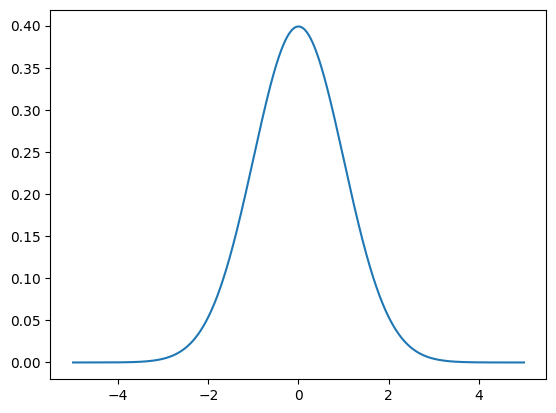

In [ ]:
# Example: For a normal distribution (mean = 0, sigma = 1)
width = 10
rate = 1000
x = np.linspace(-width/2, width/2, width*rate)
sigma = 1

func = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / sigma) ** 2)

func_moments = moments.Moments(x, func)

print(f"Mean: {func_moments.mean}")
print(f"Variance: {func_moments.variance}")
print(f"Skewness: {func_moments.all_moments[2]}")
print(f"Kurtosis: {func_moments.all_moments[3]}")

plt.plot(x, func)
plt.show()

# Tests

In [ ]:
# Variable dump
power       = 4                                                 # highest polynomial coefficient used for fitting
bw          = 2*np.pi                                           # bandwidth (Omega).
SampleRate  = 1000                                              # number of samples per unit time
SignalLen   = 20                                                # number of unit time lengths for the signal
SampleNum   = int(SampleRate*SignalLen)                         # number of samples for the signal
t           = np.linspace(-SignalLen/2, SignalLen/2, SampleNum) # timesteps to sample the wave by
coefs       = [1, -1, 1, -1, 1, -1]
sr          = bwl.SuperRandom(f_low=bw, f_high=2*bw, t=t, sinc_order=1, coefs=coefs, symmetry='even')

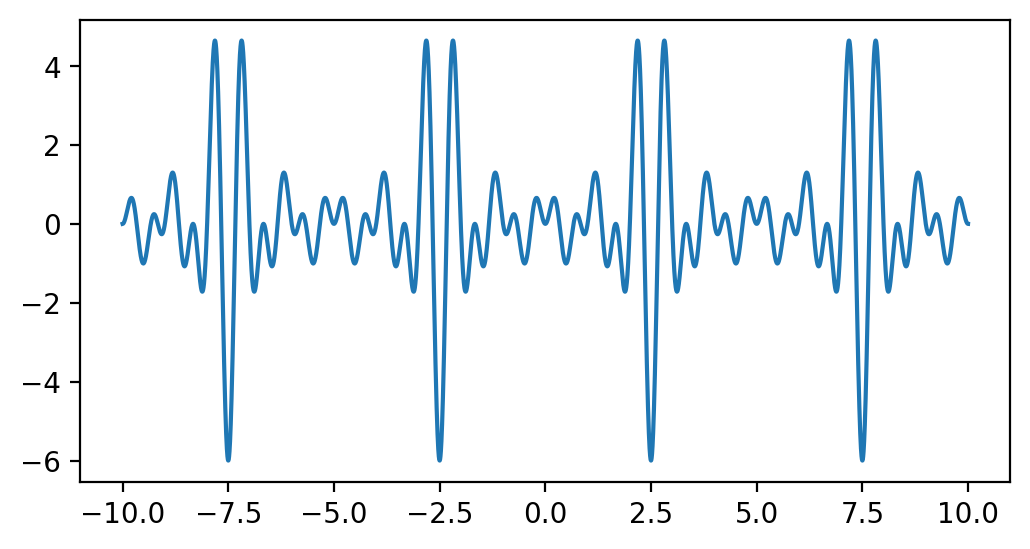

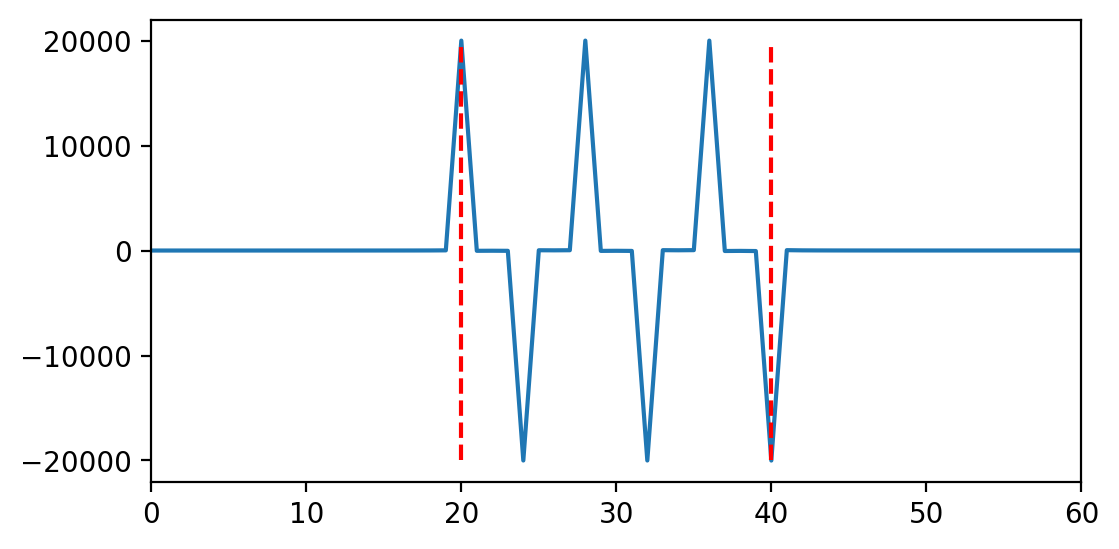

In [ ]:
# considering using these three waves as the non-superoscillating versions of the coefficient ML test.
# we should probably do everything at once: both collect the coefs
plt.rcParams['figure.figsize'] = [6, 3]
plt.rcParams['figure.dpi'] = 200

coefs = [1, -1, 1, -1, 1, -1]
sr = bwl.SuperRandom(f_low=bw, f_high=2*bw, t=t, sinc_order=1, coefs=coefs, symmetry='even')

plt.plot(sr.t, np.real(sr.signal))
plt.xlim(-2.5, 2.5)
plt.show()

plt.plot(np.real(np.fft.fft(sr.signal)))
plt.vlines(20, -20000, 20000, linestyles='dashed', colors='r')
plt.vlines(40, -20000, 20000, linestyles='dashed', colors='r')
plt.xlim(0,60)
plt.show()

In [ ]:
# find the fourier components, in order of appearance

f               = np.fft.fft(sr.signal)
indexed_values  = list(enumerate(f))
top_six         = sorted(indexed_values, key=lambda x: abs(x[1]), reverse=True)[:6]
top_six_sorted  = sorted(top_six, key=lambda x: x[0])
result          = [np.real(val) for idx, val in top_six_sorted]
result         /= np.max(np.abs(result))

print(result)

[ 0.9994323  -0.99975023  0.99950527 -0.99975129  0.99942621 -1.        ]


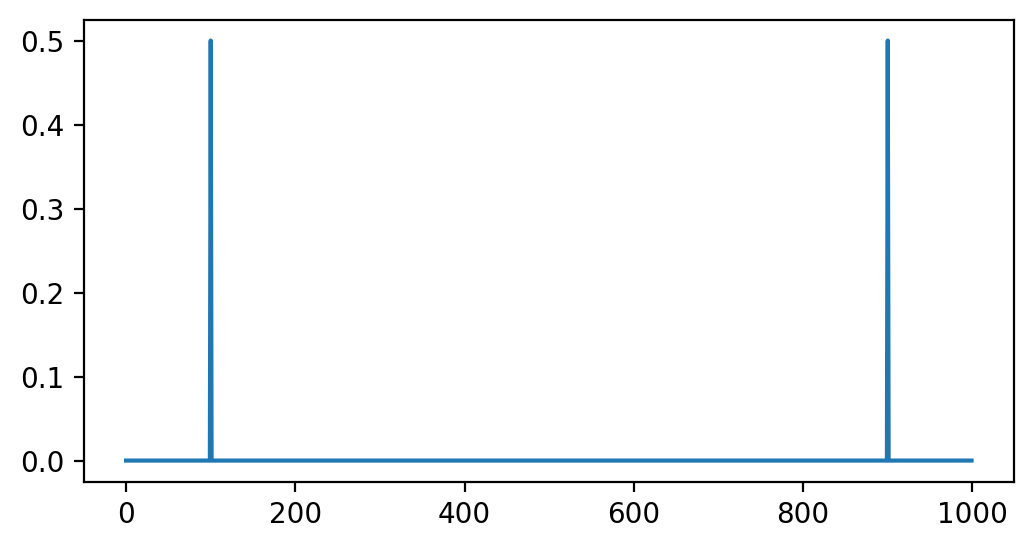

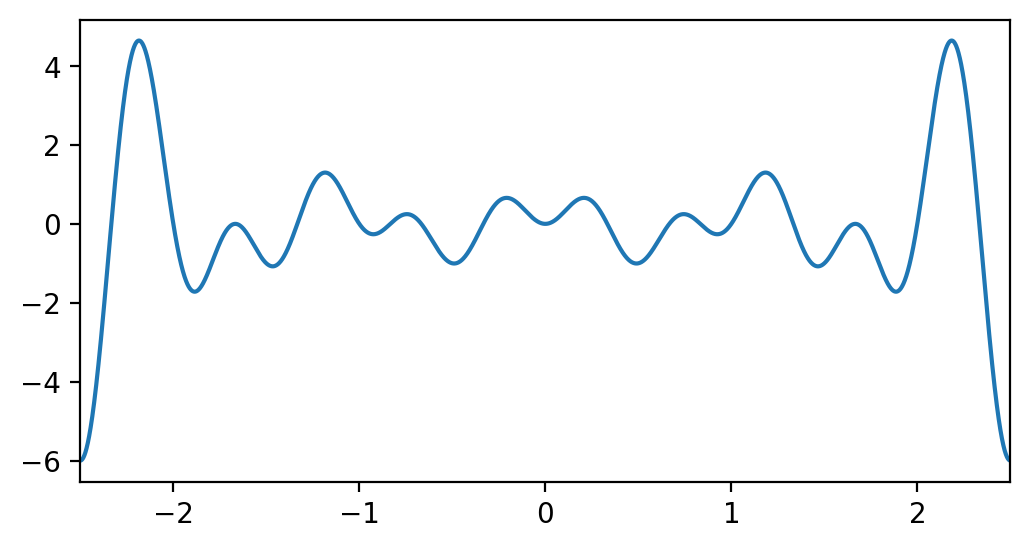

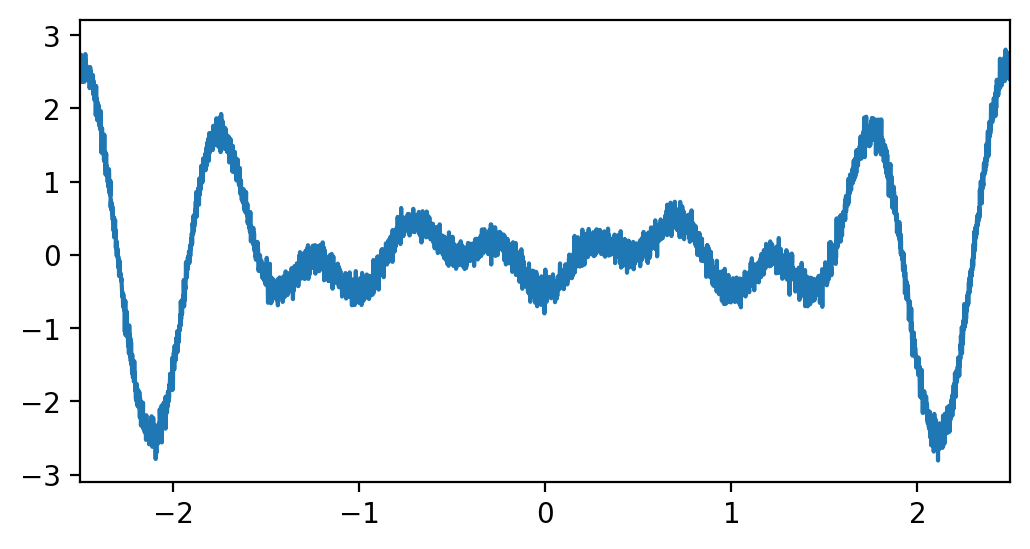

[-0.81615804  1.         -0.93266371 -0.93266371  1.         -0.81615804]


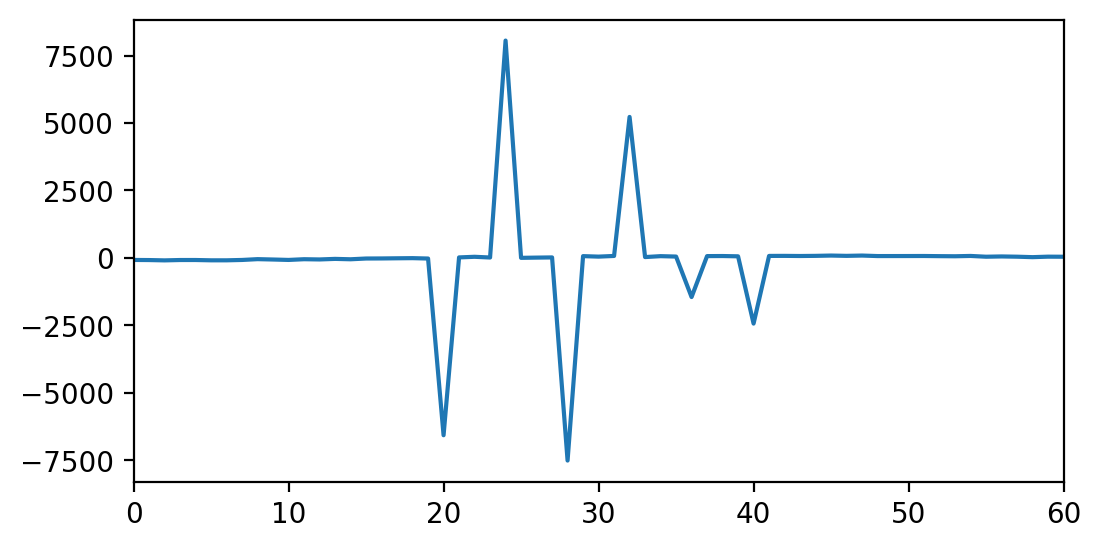

In [ ]:
# return sr scattered return wave
scatter = np.zeros(1000)
scatter[100] = .5
scatter[900] = .5

plt.plot(scatter)
plt.show()

plt.plot(sr.t, np.real(sr.signal))
plt.xlim(-2.5, 2.5)
plt.show()

rw = polyfit.create_return_wave(scatter, sr, add_noise=True, snr=10)

plt.plot(sr.t, np.real(rw))
plt.xlim(-2.5, 2.5)
plt.show()

f               = np.fft.fft(rw)
indexed_values  = list(enumerate(f))
top_six         = sorted(indexed_values, key=lambda x: abs(x[1]), reverse=True)[:6]
top_six_sorted  = sorted(top_six, key=lambda x: x[0])
result          = [np.real(val) for idx, val in top_six_sorted]
result         /= np.max(np.abs(result))

print(result)

plt.plot(np.real(f))
plt.xlim(0,60)
plt.show()

# Database

In [ ]:
def create_record(x, idx, loc1=0., loc2=0.49, loc3=0.49, amp1=0., amp2=0., amp3=0.):
    scatter = np.zeros(len(x))
    scatter[np.where(x == loc1)] = amp1
    scatter[np.where(x == loc2)] = amp2
    scatter[np.where(x == loc3)] = amp3
    if np.sum(scatter) == 0:
        print(loc1, loc2, loc3, amp1, amp2, amp3)
    ems = mfl.Moments(x, scatter)
    return np.concatenate(([loc1, loc2, loc3, amp1, amp2, amp3], ems.moments))

In [ ]:
moment_names = ['mean', 'variance', 'std', 'skew', 'kurtosis', 'inv_kurt', 'hyperskewness', 'hyperkurtosis']
cols = ['loc_1', 'loc_2', 'loc_3', 'amp_1', 'amp_2', 'amp_3'] + moment_names
print(cols)

num_records = 0

mid_low = -0.1
mid_high = 0.1
mid_step = .02
extent_low = 0.02
extent_high = 0.401
extent_step = .02

# two deltas loop
for mid in np.round(np.arange(mid_low, mid_high, mid_step), 2):
    for extent in np.round(np.arange(extent_low, extent_high, extent_step), 2):
        for amp_1 in np.round(np.arange(.05, .96, .05), 2):
            num_records += 1
# three deltas loop
for mid in np.round(np.arange(mid_low, mid_high, mid_step), 2):
    for extent in np.round(np.arange(extent_low, extent_high, extent_step), 2):
        loc_1 = np.round(mid - extent, 2)
        loc_3 = np.round(mid + extent, 2)
        for spot in np.round(np.arange(.02, extent*2-.01, .02), 2):
            for amp_1 in np.round(np.arange(.05, .91, .05), 2):
                for amp_2 in np.round(np.arange(.05, .96-amp_1, .05), 2):
                    num_records += 1

print(num_records)

x           = np.round(np.linspace(-1, 1, 2000, endpoint=False), 3)
data_array  = np.zeros((num_records, len(cols)))

start   = time.time()

idx = 0
# two deltas loop
for mid in np.round(np.arange(mid_low, mid_high, mid_step), 2):
    for extent in np.round(np.arange(extent_low, extent_high, extent_step), 2):
        loc_1 = np.round(mid - extent, 2)
        loc_2 = np.round(mid + extent, 2)
        for amp_1 in np.round(np.arange(.05, .96, .05), 2):
            amp_2 = np.round(1.0 - amp_1, 2)
            data_array[idx] = create_record(x, idx, loc1=loc_1, loc2=loc_2, amp1=amp_1, amp2=amp_2)
            idx += 1
# three deltas loop
for mid in np.round(np.arange(mid_low, mid_high, mid_step), 2):
    for extent in np.round(np.arange(extent_low, extent_high, extent_step), 2):
        loc_1 = np.round(mid - extent, 2)
        loc_3 = np.round(mid + extent, 2)
        for spot in np.round(np.arange(.02, extent*2-.01, .02), 2):
            loc_2 = np.round(spot + loc_1, 2)
            for amp_1 in np.round(np.arange(.05, .91, .05), 2):
                for amp_2 in np.round(np.arange(.05, .96-amp_1, .05), 2):
                    amp_3 = np.round(1.0 - amp_1 - amp_2, 2)
                    data_array[idx] = create_record(x, idx, loc1=loc_1, loc2=loc_2, loc3=loc_3,
                                                    amp1=amp_1, amp2=amp_2, amp3=amp_3)
                    idx += 1

                    if idx % 10000 == 0:
                        print(idx)

database    = pd.DataFrame(data_array, columns=cols)
end         = time.time()
print((end - start)/60)

['loc_1', 'loc_2', 'loc_3', 'amp_1', 'amp_2', 'amp_3', 'mean', 'variance', 'std', 'skew', 'kurtosis', 'inv_kurt', 'hyperskewness', 'hyperkurtosis']
687800
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
2.559157391389211


In [ ]:
# give a count of the number of NaNs in database
print(database.isna().sum())

loc_1            0
loc_2            0
loc_3            0
amp_1            0
amp_2            0
amp_3            0
mean             0
variance         0
std              0
skew             0
kurtosis         0
inv_kurt         0
hyperskewness    0
hyperkurtosis    0
dtype: int64


In [ ]:
# remove all records with NaN
database = database.dropna()

In [ ]:
folder = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Scatter_Distribution/'
database.to_csv(folder + 'database.csv', index=False)

# Polynomial Fits
(and new, complete database for ML training)

In [5]:
folder = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Scatter_Distribution/'
db = pd.read_csv(folder + 'database.csv')

### reports (optional)

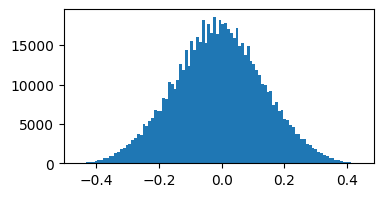

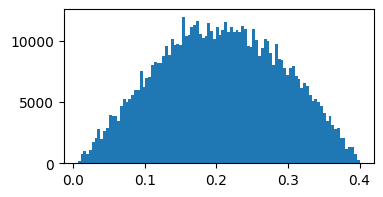

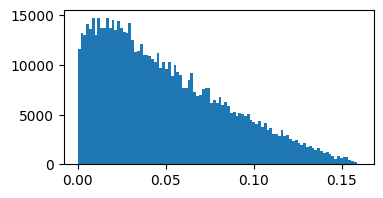

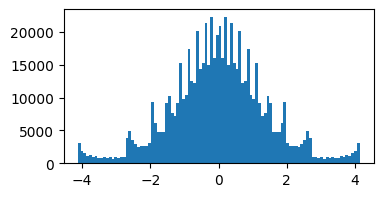

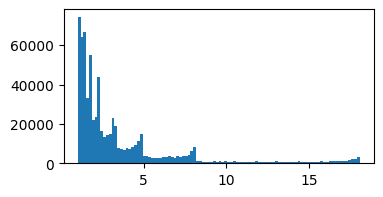

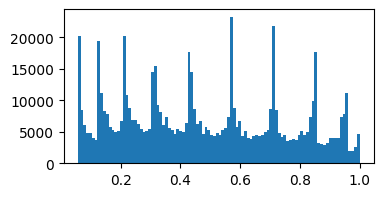

In [7]:
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 100

plt.hist(db['mean'], bins=100)
plt.show()

plt.hist(db['std'], bins=100)
plt.show()

plt.hist(db['variance'], bins=100)
plt.show()

plt.hist(db['skew'], bins=100)
plt.show()

plt.hist(db['kurtosis'], bins=100)
plt.show()

plt.hist(1/db['kurtosis'], bins=100)
plt.show()

## create base functions

In [8]:
# Variable dump
power       = 4                                                 # highest polynomial coefficient used for fitting
bw          = 2*np.pi                                           # bandwidth (Omega).
SampleRate  = 500                                               # number of samples per unit time
SignalLen   = 50                                                # number of unit time lengths for the signal
SampleNum   = int(SampleRate*SignalLen)                         # number of samples for the signal
t           = np.linspace(-SignalLen/2, SignalLen/2, SampleNum) # timesteps to sample the wave by
coefs       = [1, -1, 1, -1, 1, -1]
sr          = bwl.SuperRandom(f_low=bw, f_high=2*bw, t=t, coefs=coefs)

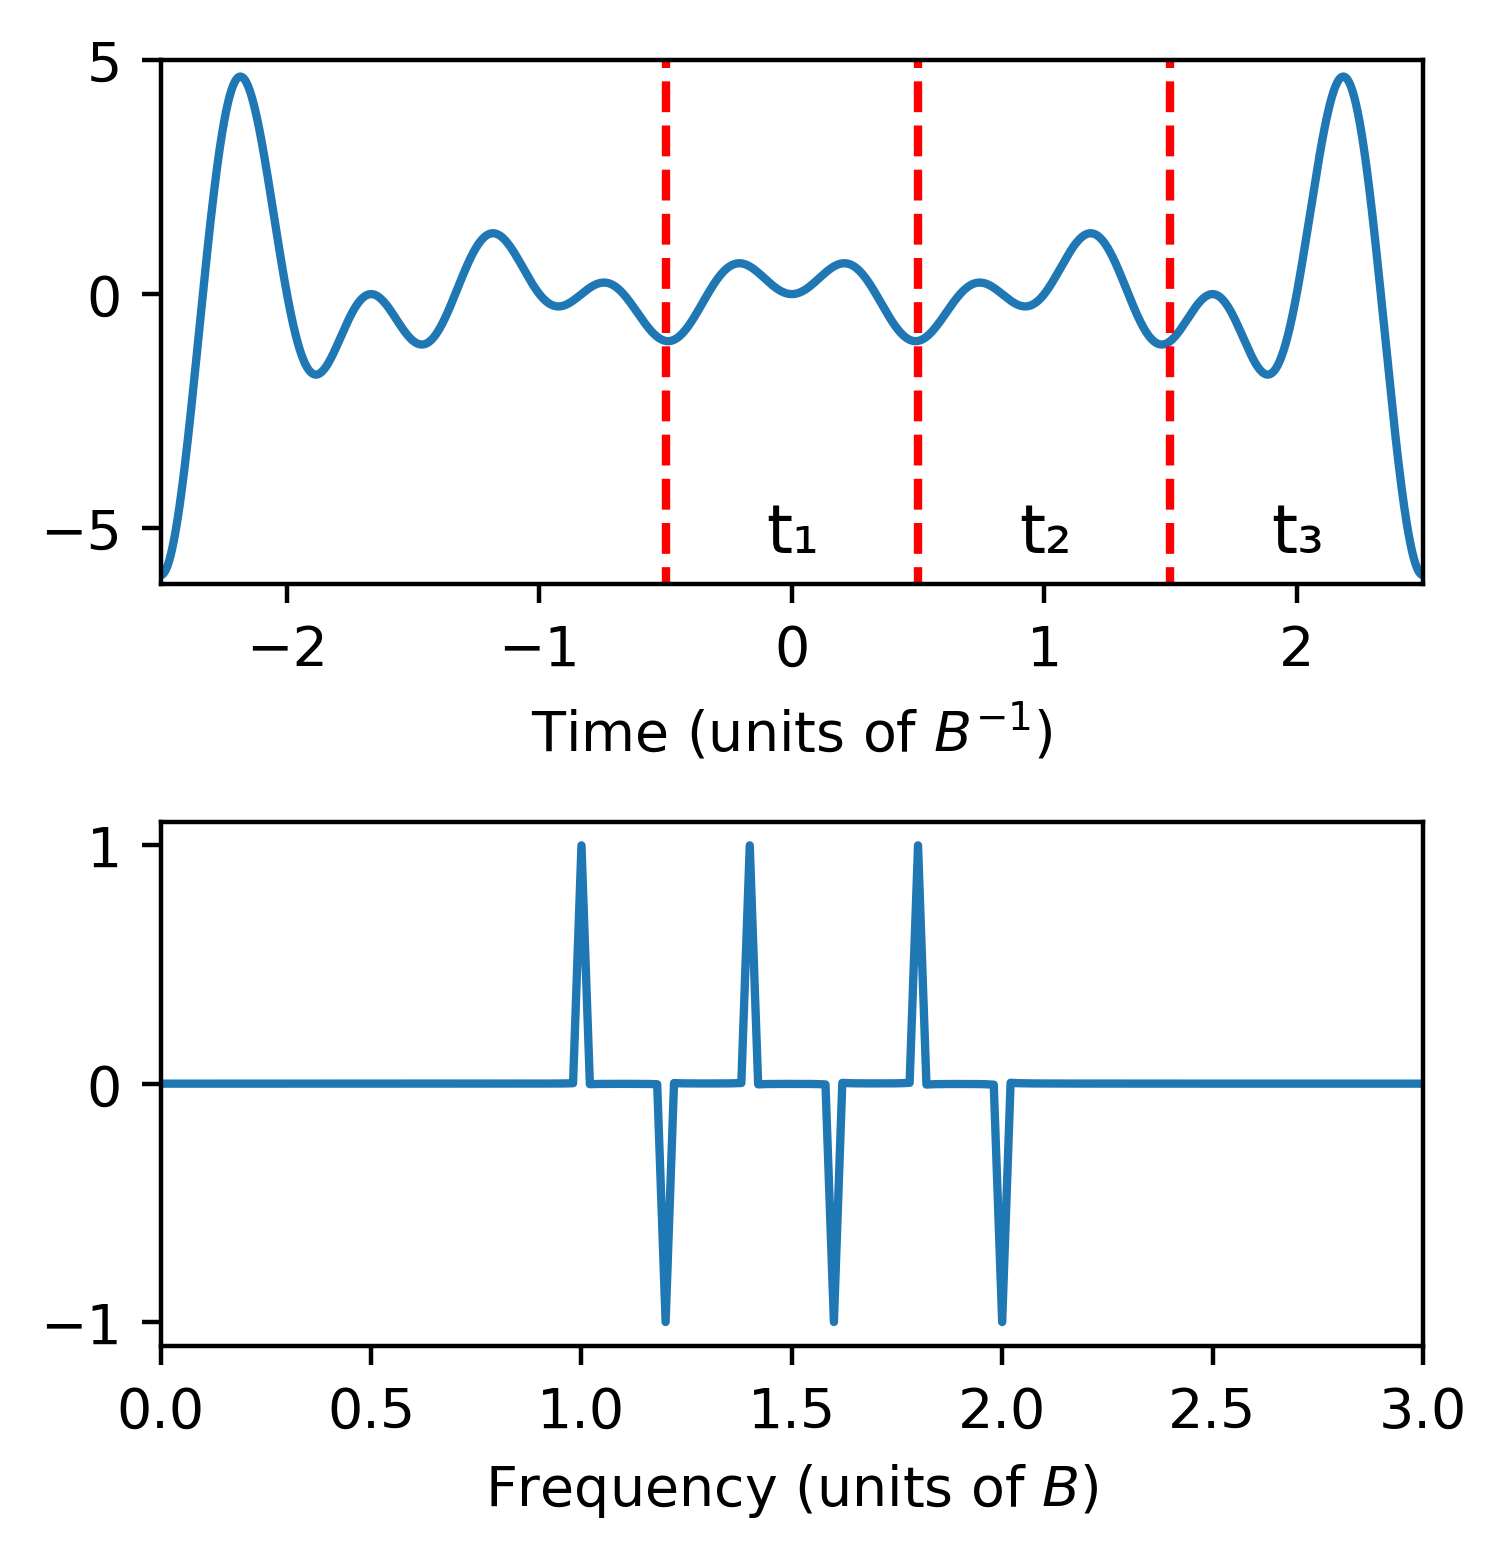

In [24]:
plt.rcParams['figure.dpi'] = 400
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

axs[0].plot(sr.t, np.real(sr.signal))
axs[0].set_xlim(-2.5, 2.5)
axs[0].set_ylim(-6.2, 5)
axs[0].set_xlabel('Time (units of $B^{-1}$)')
axs[0].vlines([-0.5, 0.5, 1.5], -6.5, 5.5, linestyles='dashed', colors='r')
axs[0].text(-0.1, -5.5, 't₁', fontsize=12)
axs[0].text(0.9, -5.5, 't₂', fontsize=12)
axs[0].text(1.9, -5.5, 't₃', fontsize=12)

ft = np.fft.fftfreq(len(sr.signal), 1/SampleRate)
fts = np.fft.fftshift(ft)
ffts = np.fft.fftshift(np.real(np.fft.fft(sr.signal)))

axs[1].plot(fts, ffts/np.max(np.abs(ffts)))
axs[1].set_xlim(0,3)
axs[1].set_xlabel('Frequency (units of $B$)')

plt.tight_layout()
plt.show()

## final database creation

### delta version

In [ ]:
power           = 4
snr             = 100
segments        = 3
freqs           = 6
real            = True
add_noise       = False if (snr == 0) else True
moment_columns  = ['loc_1', 'loc_2', 'loc_3', 'amp_1', 'amp_2', 'amp_3', 'mean', 'variance', 'std', 'skew',
                   'kurtosis', 'inv_kurt', 'hyperskewness', 'hyperkurtosis']
poly_columns    = []
freq_columns    = []

for seg in range(segments):
    for coef in range((power+1)):
        poly_columns.append(f'segment{seg}_{coef}')
for freq in range(freqs):
    freq_columns.append(f'freq_{freq}')
freq_columns.append('freq_delta')

all_columns     = moment_columns + poly_columns + freq_columns
chunk_size      = 1000
output_file     = folder + f'db_delta_snr{snr}_realfreq.csv'

if os.path.exists(output_file):
    processed_df = pd.read_csv(output_file)
    start_idx = len(processed_df)
    print(f"Resuming from record {start_idx}")
else:
    start_idx = 0
    print("Starting processing from the beginning")

st = time.time()

# Process in chunks to deal with running out of processing time
for start in range(start_idx, len(db), chunk_size):
    start_time  = time.time()
    end         = min(start + chunk_size, len(db))
    chunk       = db.iloc[start:end].copy()
    print(f"Processing records {start} to {end - 1}")

    chunk_df    = chunk.apply(lambda row: polyfit.add_poly_coefs(row, sr, power, add_noise=add_noise,
                                                                 snr=snr, FitWindow=1, segments=segments,
                                                                 freqs=freqs, real=real, SampleRate=SampleRate),
                              axis=1).tolist()
    chunk_df    = pd.DataFrame(chunk_df, columns=all_columns)

    if os.path.exists(output_file):
        chunk_df.to_csv(output_file, mode='a', header=False, index=False)
    else:
        chunk_df.to_csv(output_file, mode='w', header=True, index=False)

    end_time = time.time()

    print((end_time - start_time)/60)

et = time.time()
print("Processing complete!")
print((et - st)/60)

Starting processing from the beginning
Processing records 0 to 999
0.06956308285395305
Processing records 1000 to 1999
0.07094075679779052
Processing records 2000 to 2999
0.07096448342005411
Processing records 3000 to 3999
0.07039921283721924
Processing records 4000 to 4999
0.0703203797340393
Processing records 5000 to 5999
0.0695534348487854
Processing records 6000 to 6999
0.0699461301167806
Processing records 7000 to 7999
0.06999592383702596
Processing records 8000 to 8999
0.0702152689297994
Processing records 9000 to 9999
0.06901810169219971
Processing records 10000 to 10999
0.07177916367848715
Processing records 11000 to 11999
0.07051314115524292
Processing records 12000 to 12999
0.07002087036768595
Processing records 13000 to 13999
0.07124925057093302
Processing records 14000 to 14999
0.07006026109059652
Processing records 15000 to 15999
0.06996379693349203
Processing records 16000 to 16999
0.06989147265752156
Processing records 17000 to 17999
0.06980716387430827
Processing record

### modified norm version

#### test it

Random Record:
loc_1           -0.420000
loc_2            0.060000
loc_3            0.380000
amp_1            0.150000
amp_2            0.550000
amp_3            0.300000
mean             0.084000
variance         0.064704
std              0.254370
skew            -0.694519
kurtosis         2.861928
inv_kurt         0.349415
hyperskewness   -3.940432
hyperkurtosis    9.820586
Name: 343109, dtype: float64


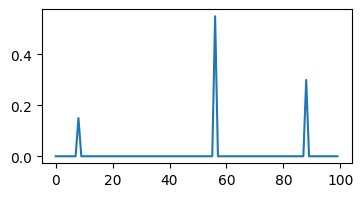

In [8]:
# random_record = db.sample(n=1).iloc[0]
# random_record = db.iloc[1915]
# random_record = db.iloc[46979]
random_record = db.iloc[343109]
print("Random Record:")
print(random_record)

scatter = np.zeros(100)
scatter[int((random_record['loc_1']+.5) * 100)] = random_record['amp_1']
scatter[int((random_record['loc_2']+.5) * 100)] = random_record['amp_2']
scatter[int((random_record['loc_3']+.5) * 100)] = random_record['amp_3']

plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 100
plt.plot(scatter)
plt.show()

mu1: -0.29613909134854527
mu2: 0.19620954723691575
sigma: 0.14844022109761063
w1: 0.22793936271070847
mean: 0.08398391232626083
variance: 0.06469404467105787
std: 0.2543502401631614
skew: -0.6945255313047503
kurtosis: 2.861888508092728
inv_kurt: 0.3494196217540418
hyperskewness: -4.051948122075467
hyperkurtosis: 12.538951533386387


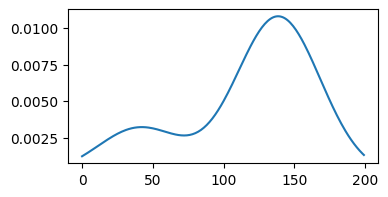

In [9]:
power           = 4
snr             = 0
segments        = 3
freqs           = 6
real            = True
add_noise       = False if (snr == 0) else True

new_record = polyfit.add_poly_coefs_norm(random_record, sr, power, add_noise=add_noise, snr=snr,segments=segments,
                                         freqs=freqs, real=real, SampleRate=SampleRate)
names = ['mu1', 'mu2', 'sigma', 'w1', 'mean', 'variance', 'std', 'skew', 'kurtosis', 'inv_kurt',
         'hyperskewness', 'hyperkurtosis']
for i in range(len(names)):
    print(f"{names[i]}: {new_record[i]}")

x = np.linspace(-.5, .5, 200)
results = [new_record[i] for i in range(4)]

plt.plot(gmm.gmm_pdf(x, results))
plt.show()

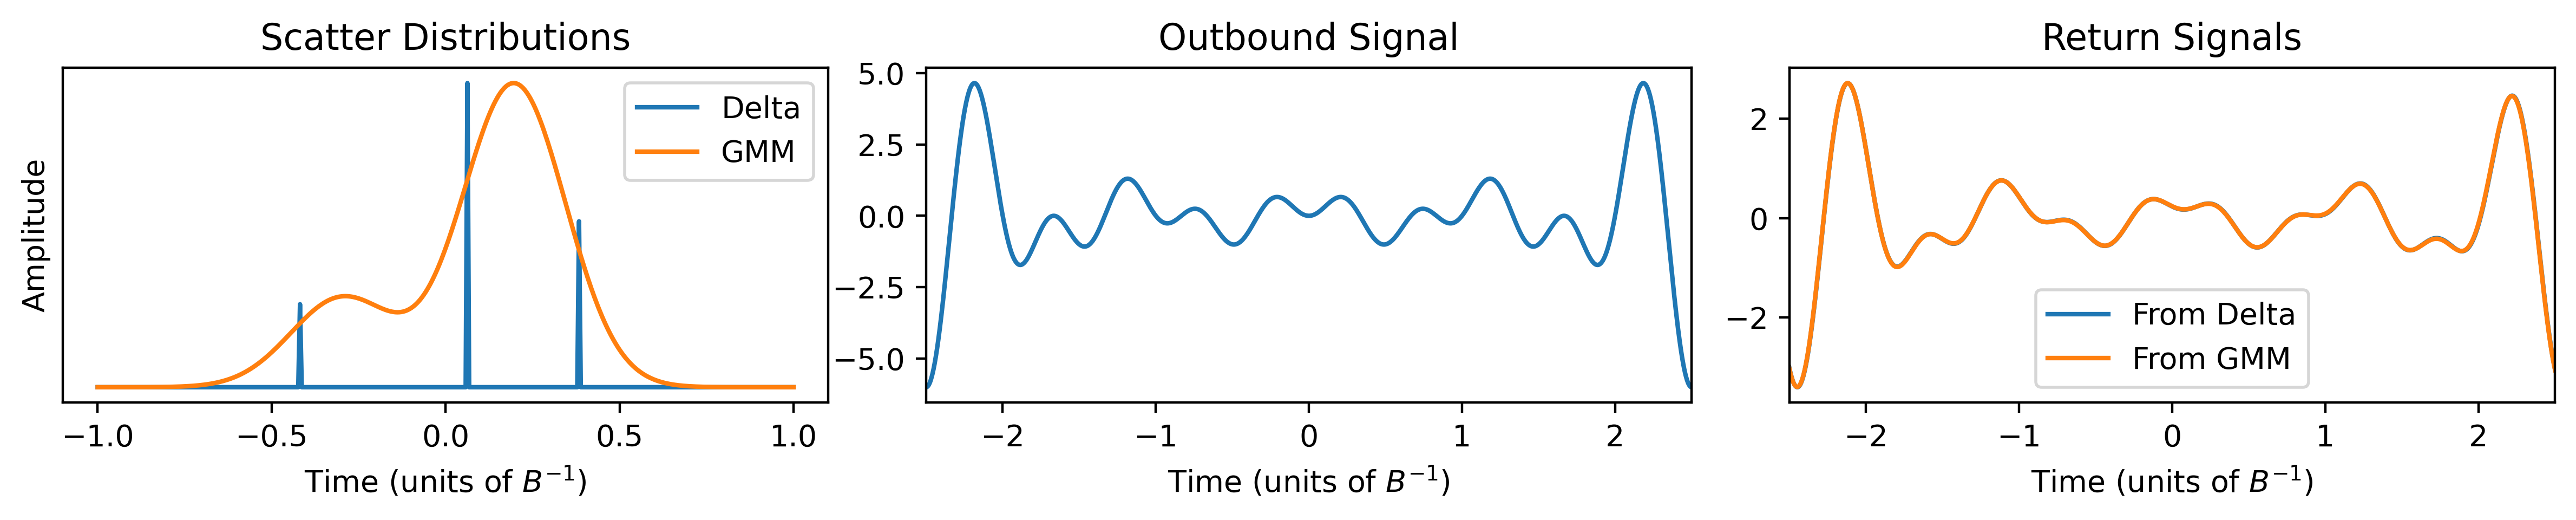

In [25]:
plt.rcParams['figure.dpi'] = 400

fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))  # 4 inches per subplot

x = np.linspace(-1, 1, 400)

scatter = np.zeros(len(x))
scatter[int((random_record['loc_1'] + 1) * 200)] = random_record['amp_1']
scatter[int((random_record['loc_2'] + 1) * 200)] = random_record['amp_2']
scatter[int((random_record['loc_3'] + 1) * 200)] = random_record['amp_3']

scatter2 = gmm.gmm_pdf(x, results)

wave1 = polyfit.create_return_wave(scatter, sr, add_noise=False, snr=0, real=True)
wave2 = polyfit.create_return_wave(scatter2, sr, add_noise=False, snr=0, real=True)

axs[0].plot(x, scatter / np.max(scatter), label="Delta")
axs[0].plot(x, scatter2 / np.max(scatter2), label="GMM")
axs[0].set_title("Scatter Distributions")
axs[0].set_xlabel("Time (units of $B^{-1}$)")
axs[0].set_ylabel("Amplitude")
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].legend()

axs[1].plot(sr.t, np.real(sr.signal))
axs[1].set_xlim(-2.5, 2.5)
axs[1].set_title("Outbound Signal")
axs[1].set_xlabel("Time (units of $B^{-1}$)")

axs[2].plot(sr.t, np.real(wave1), label="From Delta")
axs[2].plot(sr.t, np.real(wave2), label="From GMM")
axs[2].set_xlim(-2.5, 2.5)
# axs[2].set_ylim(-.6, .6)
axs[2].set_title("Return Signals")
axs[2].set_xlabel("Time (units of $B^{-1}$)")
axs[2].legend(loc='lower center')

plt.tight_layout()
plt.show()

#### run it

had to redo this to process in chunks because it otherwise took more than 24 hours to complete. since saving to file is the very last step when you do it all at once, Colab was hitting the 24 hour limit and disconnecting from the runtime before the file ever got saved. we are now saving to file, 1000 records at a time

In [ ]:
power           = 4
snr             = 100
segments        = 3
freqs           = 6
real            = True
add_noise       = False if (snr == 0) else True
moment_columns  = ['mu1', 'mu2', 'sigma', 'w1', 'mean', 'variance', 'std', 'skew', 'kurtosis', 'inv_kurt',
                   'hyperskewness', 'hyperkurtosis']
poly_columns    = []
freq_columns    = []

for seg in range(segments):
    for coef in range((power+1)):
        poly_columns.append(f'segment{seg}_{coef}')
for freq in range(freqs):
    freq_columns.append(f'freq_{freq}')
freq_columns.append('freq_delta')

all_columns     = moment_columns + poly_columns + freq_columns
chunk_size      = 1000
output_file     = folder + f'db_norm_snr{snr}_realfreq.csv'

if os.path.exists(output_file):
    processed_df = pd.read_csv(output_file)
    start_idx = len(processed_df)
    print(f"Resuming from record {start_idx}")
else:
    start_idx = 0
    print("Starting processing from the beginning")

# Process in chunks to deal with running out of processing time
for start in range(start_idx, len(db), chunk_size):
    start_time      = time.time()
    end             = min(start + chunk_size, len(db))
    chunk           = db.iloc[start:end].copy()

    print(f"Processing records {start} to {end - 1}")

    processed_chunk = chunk.apply(lambda row: polyfit.add_poly_coefs_norm(row, sr, power, FitWindow=1,
                                                                          add_noise=add_noise, snr=snr,
                                                                          segments=segments, freqs=freqs,
                                                                          real=real, SampleRate=SampleRate),
                                  axis=1).tolist()
    chunk_df        = pd.DataFrame(processed_chunk, columns=all_columns)

    if os.path.exists(output_file):
        chunk_df.to_csv(output_file, mode='a', header=False, index=False)
    else:
        chunk_df.to_csv(output_file, mode='w', header=True, index=False)

    end_time        = time.time()

    print((end_time - start_time)/60)

print("Processing complete!")

Starting processing from the beginning
Processing records 0 to 999
0.28570464452107747
Processing records 1000 to 1999
0.2853687961896261
Processing records 2000 to 2999
0.28711049954096474
Processing records 3000 to 3999
0.2877519647280375
Processing records 4000 to 4999
0.2770766854286194
Processing records 5000 to 5999
0.2767467975616455
Processing records 6000 to 6999
0.2780735572179159
Processing records 7000 to 7999
0.27833576599756876
Processing records 8000 to 8999
0.2663973569869995
Processing records 9000 to 9999
0.27297167778015136
Processing records 10000 to 10999
0.2654267907142639
Processing records 11000 to 11999
0.27407358487447103
Processing records 12000 to 12999
0.2678695797920227
Processing records 13000 to 13999
0.26594608624776206
Processing records 14000 to 14999
0.27475628852844236
Processing records 15000 to 15999
0.26383632024129233
Processing records 16000 to 16999
0.27036271890004476
Processing records 17000 to 17999
0.2731104572614034
Processing records 180